In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")
sns.set(font_scale=2)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

#### Get paths for files to process

In [2]:
#create list of dir paths
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/fentanyl'
    
RFID_file_names = os.listdir(RFID_path)

RFID_data_dir_paths = []

for file in RFID_file_names:
    int_path = RFID_path + '/' + file
    RFID_data_dir_paths.append(int_path)
    
RFID_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/fentanyl/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/fentanyl/Idspyder-22.03.23.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/fentanyl/Idspyder-22.04.13.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/fentanyl/Idspyder-22.04.07.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/fentanyl/Idspyder-22.04.06.csv']

#### Clean df and combine into 1

In [6]:
path = RFID_data_dir_paths[4]

data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')

data_RFID_int = pd.DataFrame(data = data_RFID_int)
print(data_RFID_int.shape)

data_RFID_int.head(500)

(3997, 14)


,DateTime,IdRFID,IdLabel,unitLabel,eventDuration,sense1duration,sense1Events,senseRFIDrecords,outFuncLabel,outLabel,SystemMsg,MsgValue1,MsgValue2,MsgValue3
0,#ID-Device,Spyder1.01,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#ID-Device,Spyder1.02,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#ID-Device,Spyder1.03,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#ID-Device,Spyder1.04,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#ID-Device,Spyder1.05,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,#ID-Device,Spyder1.06,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,#ID-Device,Spyder1.07,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,#ID-Device,Spyder1.08,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,#ID-Device,Spyder1.09,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,#ID-Device,Spyder1.10,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
row_drop = 25

data_RFID = pd.DataFrame()

for path in RFID_data_dir_paths[4:5]:
    print(path)

    if path.split('/')[-1] == '.DS_Store':
        continue
    
    #data_RFID_int['file'] = path.split('/')[-1]
    
    #create data table
    data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')
    data_RFID_int = pd.DataFrame(data = data_RFID_int)
    data_RFID_int = data_RFID_int.iloc[row_drop: , :]
    print(data_RFID_int.shape)
    
    #add file name
    data_RFID_int['RFID_file'] = path.split('/')[-1]
                                            
    #drop rows with no event duration
    data_RFID_int = data_RFID_int[~data_RFID_int['eventDuration'].isna()]
    print(data_RFID_int.shape)
    data_RFID_int = data_RFID_int[~data_RFID_int['DateTime'].isna()]
    print(data_RFID_int.shape)

    #convert from ms to sec
    data_RFID_int['eventDuration'] = data_RFID_int['eventDuration']/1000
    #clean up and create datetime columns
    data_RFID_int['start_datetime'] = pd.to_datetime(data_RFID_int['DateTime'], unit='d')
    #can't figure out datetime format so hard code for now
    data_RFID_int['RFID_datetime_start'] = [x.replace(year = 2022) - dt.timedelta(days = 1) for x in data_RFID_int['start_datetime']] 
    #* comment out line above and use this line only for 2.23.22 data_RFID_int['RFID_datetime_start'] = [x - dt.timedelta(days = 2) for x in data_RFID_int['start_datetime']] 
    data_RFID_int['RFID_date'] = data_RFID_int['RFID_datetime_start'].dt.date 
    data_RFID_int['RFID_day'] = data_RFID_int['RFID_datetime_start'].dt.day 
    data_RFID_int['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID_int['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
    data_RFID_int['RFID_hour'] = data_RFID_int['RFID_datetime_start'].dt.hour
    data_RFID_int['RFID_min'] = data_RFID_int['RFID_datetime_start'].dt.minute
    data_RFID_int['RFID_second'] = data_RFID_int['RFID_datetime_start'].dt.second

    if data_RFID.empty:
        data_RFID = data_RFID_int
    else:
        data_RFID = pd.concat([data_RFID, data_RFID_int], axis=0)
        
    print(data_RFID.shape,'\n')

#clean columns
data_RFID = data_RFID[['RFID_file', 'IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min', 'RFID_second']]

print(data_RFID.shape,'\n')

data_RFID.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/fentanyl/Idspyder-22.04.06.csv
(3972, 14)
(3972, 15)
(3972, 15)
(3972, 23) 

(3972, 11) 



,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second
25,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.830,2022-04-06 14:09:14.445964800,2022-04-06,6,14:09:14,14,9,14
26,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,0.075,2022-04-06 14:09:55.488988799,2022-04-06,6,14:09:55,14,9,55
27,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.316,2022-04-06 14:09:59.503996800,2022-04-06,6,14:09:59,14,9,59
28,Idspyder-22.04.06.csv,041AC160DF,Spyder1.07,0.802,2022-04-06 14:11:34.732003200,2022-04-06,6,14:11:34,14,11,34
29,Idspyder-22.04.06.csv,041AC16225,Spyder1.07,1.102,2022-04-06 14:11:39.548025600,2022-04-06,6,14:11:39,14,11,39


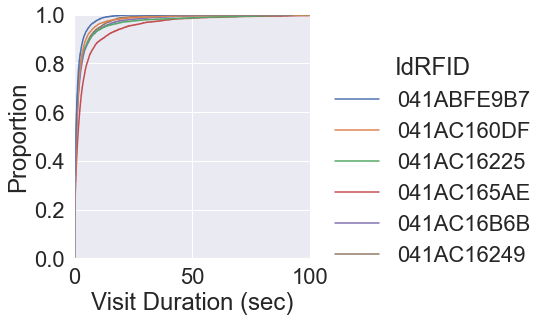

In [10]:
sns.displot(data=data_RFID, x="eventDuration", kind="ecdf", hue='IdRFID')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 100)
plt.show()

In [11]:
data_RFID['RFID_day'].value_counts()

9     9123
10    8677
8     8326
7     5079
6     3972
11    2833
Name: RFID_day, dtype: int64

In [12]:
data_RFID['IdRFID'].value_counts()

041AC16225    7884
041AC160DF    7025
041AC16B6B    6708
041ABFE9B7    6075
041AC16249    5429
041AC165AE    4889
Name: IdRFID, dtype: int64

#### Compute endtime 

In [13]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(38010, 13)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end
25,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.830,2022-04-06 14:09:14.445964800,2022-04-06,6,14:09:14,14,9,14,2022-04-06 14:09:16.275964800,14:09:16
26,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,0.075,2022-04-06 14:09:55.488988799,2022-04-06,6,14:09:55,14,9,55,2022-04-06 14:09:55.563988799,14:09:55
27,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.316,2022-04-06 14:09:59.503996800,2022-04-06,6,14:09:59,14,9,59,2022-04-06 14:10:00.819996800,14:10:00
28,Idspyder-22.04.06.csv,041AC160DF,Spyder1.07,0.802,2022-04-06 14:11:34.732003200,2022-04-06,6,14:11:34,14,11,34,2022-04-06 14:11:35.534003200,14:11:35
29,Idspyder-22.04.06.csv,041AC16225,Spyder1.07,1.102,2022-04-06 14:11:39.548025600,2022-04-06,6,14:11:39,14,11,39,2022-04-06 14:11:40.650025600,14:11:40


#### Add day, hour, and min counts

In [14]:
#column of running day count
dat_map = dict(zip(data_RFID['RFID_date'].unique(), np.arange(1,len(data_RFID['RFID_date'].unique())+1)))
data_RFID['RFID_day_count'] = data_RFID['RFID_date'].map(dat_map)

#column of running min and second count within each day
data_RFID['RFID_min_count'] = (data_RFID['RFID_hour']*60) + data_RFID['RFID_min'] 
data_RFID['RFID_sec_count'] = (data_RFID['RFID_min_count']*60) + data_RFID['RFID_second'] 

#column of running hour and minute count across all days
data_RFID['RFID_hour_count_running'] = (data_RFID['RFID_day_count']*24) + data_RFID['RFID_hour'] - 24
data_RFID['RFID_min_count_running'] = (data_RFID['RFID_hour_count_running']*60) + data_RFID['RFID_min'] 
data_RFID['RFID_sec_count_running'] = (data_RFID['RFID_min_count_running']*60) + data_RFID['RFID_second'] - 60

print(data_RFID.shape)
data_RFID.head()

(38010, 19)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
25,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.830,2022-04-06 14:09:14.445964800,2022-04-06,6,14:09:14,14,9,14,2022-04-06 14:09:16.275964800,14:09:16,1,849,50954,14,849,50894
26,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,0.075,2022-04-06 14:09:55.488988799,2022-04-06,6,14:09:55,14,9,55,2022-04-06 14:09:55.563988799,14:09:55,1,849,50995,14,849,50935
27,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.316,2022-04-06 14:09:59.503996800,2022-04-06,6,14:09:59,14,9,59,2022-04-06 14:10:00.819996800,14:10:00,1,849,50999,14,849,50939
28,Idspyder-22.04.06.csv,041AC160DF,Spyder1.07,0.802,2022-04-06 14:11:34.732003200,2022-04-06,6,14:11:34,14,11,34,2022-04-06 14:11:35.534003200,14:11:35,1,851,51094,14,851,51034
29,Idspyder-22.04.06.csv,041AC16225,Spyder1.07,1.102,2022-04-06 14:11:39.548025600,2022-04-06,6,14:11:39,14,11,39,2022-04-06 14:11:40.650025600,14:11:40,1,851,51099,14,851,51039


In [15]:
dat_map

{datetime.date(2022, 4, 6): 1,
 datetime.date(2022, 4, 7): 2,
 datetime.date(2022, 4, 8): 3,
 datetime.date(2022, 4, 9): 4,
 datetime.date(2022, 4, 10): 5,
 datetime.date(2022, 4, 11): 6}

#### Add light dark

In [17]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_RFID['ld_seg'] = data_RFID['RFID_hour'].apply(assign_ld)

print(data_RFID.shape)
data_RFID.head()


(38010, 20)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg
25,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.830,2022-04-06 14:09:14.445964800,2022-04-06,6,14:09:14,14,9,14,2022-04-06 14:09:16.275964800,14:09:16,1,849,50954,14,849,50894,light
26,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,0.075,2022-04-06 14:09:55.488988799,2022-04-06,6,14:09:55,14,9,55,2022-04-06 14:09:55.563988799,14:09:55,1,849,50995,14,849,50935,light
27,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.316,2022-04-06 14:09:59.503996800,2022-04-06,6,14:09:59,14,9,59,2022-04-06 14:10:00.819996800,14:10:00,1,849,50999,14,849,50939,light
28,Idspyder-22.04.06.csv,041AC160DF,Spyder1.07,0.802,2022-04-06 14:11:34.732003200,2022-04-06,6,14:11:34,14,11,34,2022-04-06 14:11:35.534003200,14:11:35,1,851,51094,14,851,51034,light
29,Idspyder-22.04.06.csv,041AC16225,Spyder1.07,1.102,2022-04-06 14:11:39.548025600,2022-04-06,6,14:11:39,14,11,39,2022-04-06 14:11:40.650025600,14:11:40,1,851,51099,14,851,51039,light


#### Add day/night mapping (lines up dates and ld segments)

In [18]:
ld_mapping_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/ld_mapping.xlsx'

ld_mapping = pd.read_excel(ld_mapping_path)
ld_mapping = pd.DataFrame(data = ld_mapping)
print(ld_mapping.shape)
ld_mapping.head()

(89, 4)


,day,ld_seg,ld_cycle,ld_day
0,1,light,light,light_day1
1,1,dark_pm,dark,dark_night1
2,2,light,light,light_day2
3,2,dark_pm,dark,dark_night2
4,2,dark_am,dark,dark_night1


In [19]:
data_RFID = data_RFID.merge(ld_mapping, right_on=['day', 'ld_seg'], left_on=['RFID_day_count', 'ld_seg'])
print(data_RFID.shape)
data_RFID.head()

(38010, 23)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day
0,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.830,2022-04-06 14:09:14.445964800,2022-04-06,6,14:09:14,14,9,14,2022-04-06 14:09:16.275964800,14:09:16,1,849,50954,14,849,50894,light,1,light,light_day1
1,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,0.075,2022-04-06 14:09:55.488988799,2022-04-06,6,14:09:55,14,9,55,2022-04-06 14:09:55.563988799,14:09:55,1,849,50995,14,849,50935,light,1,light,light_day1
2,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.316,2022-04-06 14:09:59.503996800,2022-04-06,6,14:09:59,14,9,59,2022-04-06 14:10:00.819996800,14:10:00,1,849,50999,14,849,50939,light,1,light,light_day1
3,Idspyder-22.04.06.csv,041AC160DF,Spyder1.07,0.802,2022-04-06 14:11:34.732003200,2022-04-06,6,14:11:34,14,11,34,2022-04-06 14:11:35.534003200,14:11:35,1,851,51094,14,851,51034,light,1,light,light_day1
4,Idspyder-22.04.06.csv,041AC16225,Spyder1.07,1.102,2022-04-06 14:11:39.548025600,2022-04-06,6,14:11:39,14,11,39,2022-04-06 14:11:40.650025600,14:11:40,1,851,51099,14,851,51039,light,1,light,light_day1


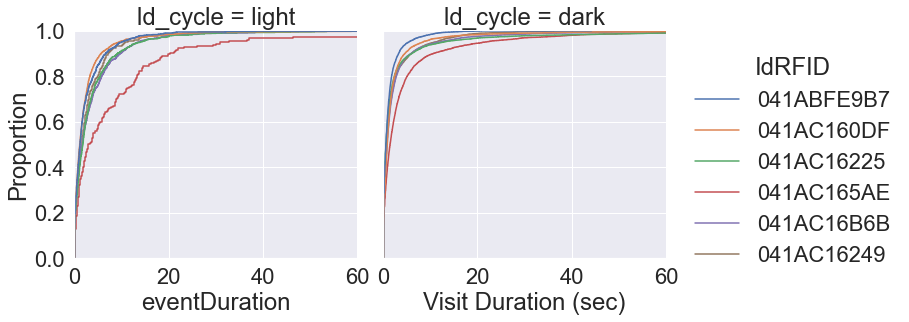

In [20]:
sns.displot(data=data_RFID, x="eventDuration", kind="ecdf", hue='IdRFID', col='ld_cycle')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 60)
plt.show()

In [21]:
data_RFID.groupby(['unitLabel'])['IdRFID'].value_counts()

unitLabel   IdRFID    
Spyder1.01  041AC16B6B    2379
            041ABFE9B7    2178
            041AC16249    1690
Spyder1.02  041AC16B6B    1865
            041AC16249    1380
            041ABFE9B7    920 
Spyder1.03  041AC16B6B    898 
            041AC16249    736 
            041ABFE9B7    676 
Spyder1.04  041ABFE9B7    2297
            041AC16249    1622
            041AC16B6B    1565
Spyder1.05  041AC16225    3191
Spyder1.06  041AC16225    1631
Spyder1.07  041AC16225    1071
            041ABFE9B7    3   
            041AC160DF    1   
            041AC165AE    1   
Spyder1.08  041AC16225    1989
Spyder1.09  041AC165AE    2509
Spyder1.10  041AC165AE    479 
Spyder1.11  041AC165AE    1211
Spyder1.12  041AC165AE    687 
Spyder1.13  041AC160DF    1934
Spyder1.14  041AC160DF    1626
Spyder1.15  041AC160DF    1038
Spyder1.16  041AC160DF    2425
Spyder1.21  041ABFE9B7    1   
            041AC160DF    1   
            041AC16225    1   
            041AC16249    1   
            041A

#### Map unitLabel and bottle contents

In [22]:
RFID_bottle_assignment_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/bottle_assignment_RFID.xlsx'

RFID_bottle_assignment = pd.read_excel(RFID_bottle_assignment_path)
RFID_bottle_assignment = pd.DataFrame(data = RFID_bottle_assignment)
print(RFID_bottle_assignment.shape)
RFID_bottle_assignment.head()

(13, 35)


,cohort,RFID_file,VDM_file,Spyder1.01,Spyder1.02,Spyder1.03,Spyder1.04,Spyder1.05,Spyder1.06,Spyder1.07,Spyder1.08,Spyder1.09,Spyder1.10,Spyder1.11,Spyder1.12,Spyder1.13,Spyder1.14,Spyder1.15,Spyder1.16,Spyder1.17,Spyder1.18,Spyder1.19,Spyder1.20,Spyder1.21,Spyder1.22,Spyder1.23,Spyder1.24,Spyder1.25,Spyder1.26,Spyder1.27,Spyder1.28,Spyder1.29,Spyder1.30,Spyder1.31,Spyder1.32
0,plain_fent,Idspyder-22.03.23.csv,5.10.20.h20_m_220323.csv,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water
1,plain_fent,Idspyder-22.04.06.csv,5.10.20.h20_f_220406.csv,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water
2,plain_fent,Idspyder-22.04.07.csv,5.10.20.h20_f_220407.csv,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water,fent_05,fent_10,fent_20,water
3,poly,Idspyder-22.04.20.csv,f20_w_e10_f5_w_e5_mf_220420.csv,fent_20,water_1,etoh_10,fent_05,water_2,etoh_05,fent_20,water_1,etoh_10,fent_05,water_2,etoh_05,fent_20,water_1,etoh_10,fent_05,water_2,etoh_05,fent_20,water_1,etoh_10,fent_05,water_2,etoh_05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,poly,Idspyder-22.05.04.csv,f20_w_e10_f5_w_e5_mf_220504.csv,fent_20,water_1,etoh_10,fent_05,water_2,etoh_05,fent_20,water_1,etoh_10,fent_05,water_2,etoh_05,fent_20,water_1,etoh_10,fent_05,water_2,etoh_05,fent_20,water_1,etoh_10,fent_05,water_2,etoh_05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
file=data_RFID['RFID_file'].unique()[0]
RFID_bottle_map = RFID_bottle_assignment[RFID_bottle_assignment['RFID_file']==file].reset_index().loc[0,'Spyder1.01':'Spyder1.32'].to_dict()

data_RFID['unitLabel_drink'] = data_RFID['unitLabel'].map(RFID_bottle_map)
print(data_RFID.shape)

data_RFID.head()

(38010, 24)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day,unitLabel_drink
0,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.830,2022-04-06 14:09:14.445964800,2022-04-06,6,14:09:14,14,9,14,2022-04-06 14:09:16.275964800,14:09:16,1,849,50954,14,849,50894,light,1,light,light_day1,fent_20
1,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,0.075,2022-04-06 14:09:55.488988799,2022-04-06,6,14:09:55,14,9,55,2022-04-06 14:09:55.563988799,14:09:55,1,849,50995,14,849,50935,light,1,light,light_day1,fent_20
2,Idspyder-22.04.06.csv,041ABFE9B7,Spyder1.07,1.316,2022-04-06 14:09:59.503996800,2022-04-06,6,14:09:59,14,9,59,2022-04-06 14:10:00.819996800,14:10:00,1,849,50999,14,849,50939,light,1,light,light_day1,fent_20
3,Idspyder-22.04.06.csv,041AC160DF,Spyder1.07,0.802,2022-04-06 14:11:34.732003200,2022-04-06,6,14:11:34,14,11,34,2022-04-06 14:11:35.534003200,14:11:35,1,851,51094,14,851,51034,light,1,light,light_day1,fent_20
4,Idspyder-22.04.06.csv,041AC16225,Spyder1.07,1.102,2022-04-06 14:11:39.548025600,2022-04-06,6,14:11:39,14,11,39,2022-04-06 14:11:40.650025600,14:11:40,1,851,51099,14,851,51039,light,1,light,light_day1,fent_20


In [24]:
data_RFID['unitLabel'].value_counts()

Spyder1.01    6247
Spyder1.04    5484
Spyder1.02    4165
Spyder1.05    3191
Spyder1.09    2509
Spyder1.16    2425
Spyder1.03    2310
Spyder1.08    1989
Spyder1.13    1934
Spyder1.06    1631
Spyder1.14    1626
Spyder1.11    1211
Spyder1.07    1076
Spyder1.15    1038
Spyder1.12    687 
Spyder1.10    479 
Spyder1.21    6   
Spyder1.24    2   
Name: unitLabel, dtype: int64

#### Add metadata and clean

In [25]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/meta_data_singleflav.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape)
data_RFID_final.head()

(38010, 39)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,index,RFID_file,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day,unitLabel_drink
0,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,7,Idspyder-22.04.06.csv,Spyder1.21,1.373,2022-04-06 15:17:21.590966400,2022-04-06,6,15:17:21,15,17,21,2022-04-06 15:17:22.963966400,15:17:22,1,917,55041,15,917,54981,light,1,light,light_day1,fent_05
1,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,48,Idspyder-22.04.06.csv,Spyder1.02,10.356,2022-04-06 15:24:04.083033600,2022-04-06,6,15:24:04,15,24,4,2022-04-06 15:24:14.439033600,15:24:14,1,924,55444,15,924,55384,light,1,light,light_day1,fent_10
2,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,55,Idspyder-22.04.06.csv,Spyder1.04,2.004,2022-04-06 15:24:41.084956800,2022-04-06,6,15:24:41,15,24,41,2022-04-06 15:24:43.088956800,15:24:43,1,924,55481,15,924,55421,light,1,light,light_day1,water
3,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,56,Idspyder-22.04.06.csv,Spyder1.04,2.405,2022-04-06 15:24:45.003024000,2022-04-06,6,15:24:45,15,24,45,2022-04-06 15:24:47.408024000,15:24:47,1,924,55485,15,924,55425,light,1,light,light_day1,water
4,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,64,Idspyder-22.04.06.csv,Spyder1.03,1.882,2022-04-06 15:25:49.629014399,2022-04-06,6,15:25:49,15,25,49,2022-04-06 15:25:51.511014399,15:25:51,1,925,55549,15,925,55489,light,1,light,light_day1,fent_20


In [26]:
data_RFID_final = data_RFID_final[['Round', 'Build', 'Timepoint', 'Cage', 'IdRFID', 'Animal', 'Injury', 'Sex', 'Cage_N', 
                                   'unitLabel_drink', 'unitLabel', 'eventDuration',
                                   'ld_cycle', 'ld_day', 'day', 'RFID_hour', 'RFID_min', 'RFID_second',
                                   'RFID_datetime_start', 'RFID_datetime_end', 'RFID_time_start', 'RFID_time_end', 
                                   'RFID_min_count', 'RFID_sec_count', 
                                   'RFID_hour_count_running', 'RFID_min_count_running', 'RFID_sec_count_running', 
                                   'RFID_file', 'weight_pre', 'weight_post', 'weight_diff', 'notes',]]

print(data_RFID_final.shape)
data_RFID_final.head()

(38010, 32)


,Round,Build,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes
0,fentanyl,four_eight,na,5,041AC16B6B,NaN,na,female,3,fent_05,Spyder1.21,1.373,light,light_day1,1,15,17,21,2022-04-06 15:17:21.590966400,2022-04-06 15:17:22.963966400,15:17:21,15:17:22,917,55041,15,917,54981,Idspyder-22.04.06.csv,22.7,NaN,NaN,NaN
1,fentanyl,four_eight,na,5,041AC16B6B,NaN,na,female,3,fent_10,Spyder1.02,10.356,light,light_day1,1,15,24,4,2022-04-06 15:24:04.083033600,2022-04-06 15:24:14.439033600,15:24:04,15:24:14,924,55444,15,924,55384,Idspyder-22.04.06.csv,22.7,NaN,NaN,NaN
2,fentanyl,four_eight,na,5,041AC16B6B,NaN,na,female,3,water,Spyder1.04,2.004,light,light_day1,1,15,24,41,2022-04-06 15:24:41.084956800,2022-04-06 15:24:43.088956800,15:24:41,15:24:43,924,55481,15,924,55421,Idspyder-22.04.06.csv,22.7,NaN,NaN,NaN
3,fentanyl,four_eight,na,5,041AC16B6B,NaN,na,female,3,water,Spyder1.04,2.405,light,light_day1,1,15,24,45,2022-04-06 15:24:45.003024000,2022-04-06 15:24:47.408024000,15:24:45,15:24:47,924,55485,15,924,55425,Idspyder-22.04.06.csv,22.7,NaN,NaN,NaN
4,fentanyl,four_eight,na,5,041AC16B6B,NaN,na,female,3,fent_20,Spyder1.03,1.882,light,light_day1,1,15,25,49,2022-04-06 15:25:49.629014399,2022-04-06 15:25:51.511014399,15:25:49,15:25:51,925,55549,15,925,55489,Idspyder-22.04.06.csv,22.7,NaN,NaN,NaN


In [27]:
data_RFID_final.groupby('Sex')['Cage'].value_counts()

Sex     Cage
female  5       18212
        6       7884 
        8       7025 
        7       4889 
Name: Cage, dtype: int64

In [28]:
data_RFID_final.to_csv('RFID_220406.csv')

#### Viz

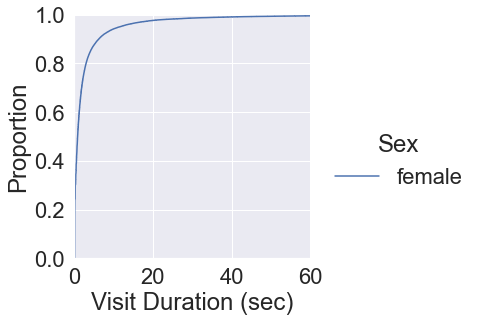

In [29]:
data_int = data_RFID_final
sns.displot(data=data_int, x="eventDuration", kind="ecdf", hue='Sex')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 60)
plt.show()

<Figure size 720x360 with 0 Axes>

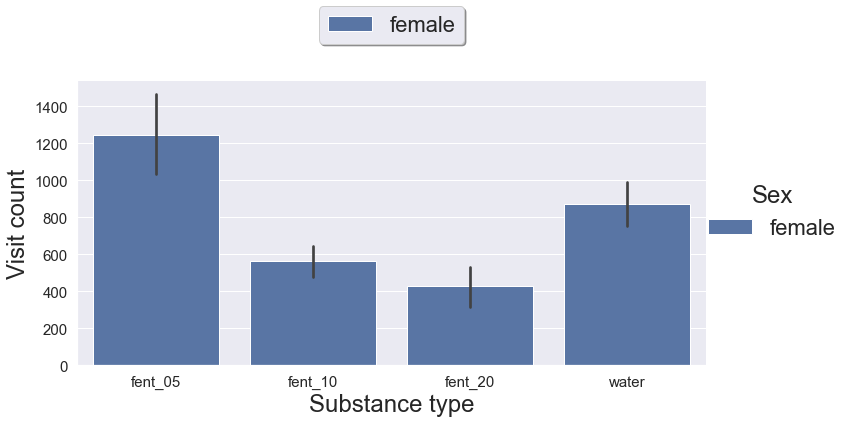

In [30]:
data_int = data_RFID_final

data_int = data_int.groupby(['Sex', 'IdRFID', 'Cage_N', 'day', 'unitLabel_drink'])['eventDuration'].sum().reset_index(name='count')

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.catplot(data=data_int, x="unitLabel_drink", y='count', hue="Sex", kind='bar', height=5, aspect=2, ci=68,)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), 
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

### VDM data

#### Make and clean df

In [31]:
#create list of dir paths
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/fentanyl'
    
VDM_file_names = os.listdir(VDM_path)

VDM_data_dir_paths = []

for file in VDM_file_names:
    int_path = VDM_path + '/' + file
    VDM_data_dir_paths.append(int_path)
    
VDM_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/fentanyl/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/fentanyl/5.10.20.h20_m_220323.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/fentanyl/5.10.20.h20_f_220406.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/fentanyl/5.10.20.h20_f_220407.csv']

In [36]:
data_VDM_int = pd.read_table(VDM_data_dir_paths[3], sep=';')
data_VDM_int = pd.DataFrame(data = data_VDM_int)
data_VDM_int.head(50)

,Columbus Instruments Device Interface Version 1.5
0,"Started On:,04/07/22 10:12:46"
1,[Experiment Setup Info]
2,"Program Path:,C:\Users\PhenoUser\Desktop\CI Multi-Device Interface"
3,"Data Path:,C:\Users\PhenoUser\Desktop\CI Multi-Device Interface\Data"
4,"Experiment File Name:,C:\Users\PhenoUser\Documents\VDM\final_setup\5.10.20.h20_f_220407.csv"
5,"Session Interval:,00:00:01"
6,"Experiment Duration:,0"
7,"Staggered Start Enable:,False"
8,[Channel Setup Info]
9,"Cage 1,Cage1"


In [37]:
row_drop = 22
data_VDM = pd.DataFrame()

for path in VDM_data_dir_paths[3:4]:
    print(path)
    
    if path.split('/')[-1] == '.DS_Store':
        continue
        
    #create data table
    data_VDM_int = pd.read_table(path, sep=';')
    data_VDM_int = pd.DataFrame(data = data_VDM_int)
    data_VDM_int = data_VDM_int.iloc[row_drop: , :]['Columbus Instruments Device Interface Version 1.5'].str.split(',', expand=True)
    data_VDM_int.columns = data_VDM_int.loc[row_drop].values
    data_VDM_int = data_VDM_int.drop(row_drop)
    
    data_VDM_int['VDM_file'] = path.split('/')[-1]

    if data_VDM.empty:
        data_VDM = data_VDM_int
    else:
        data_VDM = pd.concat([data_VDM, data_VDM_int], axis=0)
        
    print(data_VDM.shape,'\n')

print(data_VDM.shape)
data_VDM.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/fentanyl/5.10.20.h20_f_220407.csv
(1784026, 13) 

(1784026, 13)


,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),,VDM_file
23,0,1,04/07/22 10:12:51,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,5.10.20.h20_f_220407.csv
24,0,2,04/07/22 10:12:51,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,5.10.20.h20_f_220407.csv
25,0,3,04/07/22 10:12:51,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,5.10.20.h20_f_220407.csv
26,0,4,04/07/22 10:12:51,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,5.10.20.h20_f_220407.csv
27,0,5,04/07/22 10:12:51,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,5.10.20.h20_f_220407.csv


#### clean 

In [40]:
data_VDM.columns

Index(['Int', 'Cage', 'Time', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', '', 'VDM_file'], dtype='object')

In [41]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'drink_1', 'drink_1_accum',
                    'drink_2', 'drink_2_accum',
                    'drink_3', 'drink_3_accum',
                    'drink_4', 'drink_4_accum',
                    'blank', 'VDM_file']

data_VDM = data_VDM[['VDM_file', 'Cage_VDM', 'VDM_Time', 
                    'drink_1', 
                    'drink_2', 
                    'drink_3', 
                    'drink_4', 
                    ]]

data_VDM.tail()

,VDM_file,Cage_VDM,VDM_Time,drink_1,drink_2,drink_3,drink_4
96603,5.10.20.h20_f_220406.csv,5,04/07/22 10:06:40,0.000,0.000,0.000,0.000
96604,5.10.20.h20_f_220406.csv,6,04/07/22 10:06:40,0.000,0.000,0.000,0.000
96605,5.10.20.h20_f_220406.csv,7,04/07/22 10:06:40,0.000,0.000,0.000,0.000
96606,5.10.20.h20_f_220406.csv,8,04/07/22 10:06:40,0.000,0.000,0.000,0.000
96607,5.10.20.h20_f_220406.csv,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
data_VDM.head()

,VDM_file,Cage_VDM,VDM_Time,drink_1,drink_2,drink_3,drink_4
23,5.10.20.h20_f_220406.csv,1,04/07/22 10:12:51,0.000,0.000,0.000,0.000
24,5.10.20.h20_f_220406.csv,2,04/07/22 10:12:51,0.000,0.000,0.000,0.000
25,5.10.20.h20_f_220406.csv,3,04/07/22 10:12:51,0.000,0.000,0.000,0.000
26,5.10.20.h20_f_220406.csv,4,04/07/22 10:12:51,0.000,0.000,0.000,0.000
27,5.10.20.h20_f_220406.csv,5,04/07/22 10:12:51,0.000,0.000,0.000,0.000


#### Make into tidy df

In [43]:
#melt dataframe (new column of parameters)

meta_params = ['VDM_file', 'Cage_VDM', 'VDM_Time']
intake_params = ['drink_1', 'drink_2', 'drink_3', 'drink_4']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

data_VDM_tidy = data_VDM_tidy.replace({'':0.000})

data_VDM_tidy['value'] = data_VDM_tidy['value'].astype('float')

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(7522444, 5)


,VDM_file,Cage_VDM,VDM_Time,variable,value
0,5.10.20.h20_f_220406.csv,1,04/07/22 10:12:51,drink_1,0.0
1,5.10.20.h20_f_220406.csv,2,04/07/22 10:12:51,drink_1,0.0
2,5.10.20.h20_f_220406.csv,3,04/07/22 10:12:51,drink_1,0.0
3,5.10.20.h20_f_220406.csv,4,04/07/22 10:12:51,drink_1,0.0
4,5.10.20.h20_f_220406.csv,5,04/07/22 10:12:51,drink_1,0.0


In [44]:
data_VDM_tidy['value'].unique()

array([0.   , 0.032, 0.031, 0.028, 0.062, 0.064,   nan, 0.046, 0.024,
       0.027, 0.026, 0.023, 0.069, 0.092, 0.029, 0.054, 0.145, 0.052])

#### Drop times with no intake data

In [45]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0.000]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(3079, 5)


,VDM_file,Cage_VDM,VDM_Time,variable,value
164,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:23,drink_1,0.032
172,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:25,drink_1,0.032
429,5.10.20.h20_f_220406.csv,6,04/07/22 10:14:16,drink_1,0.031
478,5.10.20.h20_f_220406.csv,7,04/07/22 10:14:25,drink_1,0.031
687,5.10.20.h20_f_220406.csv,8,04/07/22 10:15:07,drink_1,0.028


#### Clean up datetime

In [46]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
#only use this for 2.23.22 data_VDM_tidy_intake['VDM_datetime'] = [x.replace(year = 2092) for x in data_VDM_tidy_intake['VDM_datetime']] 
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute
data_VDM_tidy_intake['VDM_second'] = data_VDM_tidy_intake['VDM_datetime'].dt.second

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(3079, 13)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second
164,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:23,drink_1,0.032,2022-04-07 10:13:23,1.649326e+09,2022-04-07,7,10:13:23,10,13,23
172,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:25,drink_1,0.032,2022-04-07 10:13:25,1.649326e+09,2022-04-07,7,10:13:25,10,13,25
429,5.10.20.h20_f_220406.csv,6,04/07/22 10:14:16,drink_1,0.031,2022-04-07 10:14:16,1.649326e+09,2022-04-07,7,10:14:16,10,14,16
478,5.10.20.h20_f_220406.csv,7,04/07/22 10:14:25,drink_1,0.031,2022-04-07 10:14:25,1.649326e+09,2022-04-07,7,10:14:25,10,14,25
687,5.10.20.h20_f_220406.csv,8,04/07/22 10:15:07,drink_1,0.028,2022-04-07 10:15:07,1.649327e+09,2022-04-07,7,10:15:07,10,15,7


In [47]:
data_VDM_tidy_intake['VDM_day'].value_counts()

10    761
9     749
8     729
7     392
11    356
6     92 
Name: VDM_day, dtype: int64

#### Add light dark and clean

In [48]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
164,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:23,drink_1,0.032,2022-04-07 10:13:23,1.649326e+09,2022-04-07,7,10:13:23,10,13,23,light
172,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:25,drink_1,0.032,2022-04-07 10:13:25,1.649326e+09,2022-04-07,7,10:13:25,10,13,25,light
429,5.10.20.h20_f_220406.csv,6,04/07/22 10:14:16,drink_1,0.031,2022-04-07 10:14:16,1.649326e+09,2022-04-07,7,10:14:16,10,14,16,light
478,5.10.20.h20_f_220406.csv,7,04/07/22 10:14:25,drink_1,0.031,2022-04-07 10:14:25,1.649326e+09,2022-04-07,7,10:14:25,10,14,25,light
687,5.10.20.h20_f_220406.csv,8,04/07/22 10:15:07,drink_1,0.028,2022-04-07 10:15:07,1.649327e+09,2022-04-07,7,10:15:07,10,15,7,light


#### Map bottle contents

In [49]:
VDM_bottle_assignment_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/bottle_assignment_VDM.xlsx'

VDM_bottle_assignment = pd.read_excel(VDM_bottle_assignment_path)
VDM_bottle_assignment = pd.DataFrame(data = VDM_bottle_assignment)
print(VDM_bottle_assignment.shape)
VDM_bottle_assignment

(75, 7)


,cohort,VDM_file,Cage_VDM,drink_1,drink_2,drink_3,drink_4
0,flavor,c.o.br.g_mfc2_210811.csv,NaN,VDM_cherry,VDM_orange,VDM_blueras,VDM_grape
1,flavor,g.go.o.w_mfc2_210813.csv,NaN,VDM_grape,VDM_grange,VDM_orange,VDM_water
2,flavor,br.c.g.o_fm_211111.csv,NaN,VDM_blueras,VDM_cherry,VDM_grape,VDM_orange
3,flavor,c.br.o.g_fm_211213.csv,NaN,VDM_cherry,VDM_blueras,VDM_orange,VDM_grape
4,flavor,br.c.g.o_switchfm_211220.csv,NaN,VDM_cherry,VDM_blueras,VDM_orange,VDM_grape
5,etoh,5.10.20.h20_fm_220105.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_water
6,etoh,5.10.20.h20_m_220119.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_water
7,etoh,5.10.20.h20_f_220126.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_water
8,etoh,5.10.20.h20_m_220209.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_water
9,etoh,5.10.20.h20_m_220216.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_water


In [50]:
file=data_VDM_tidy_intake['VDM_file'].unique()[0]
VDM_bottle_map = VDM_bottle_assignment[VDM_bottle_assignment['VDM_file']==file].reset_index().loc[0,'drink_1':'drink_4'].to_dict()

data_VDM_tidy_intake['VDM_drink'] = data_VDM_tidy_intake['variable'].map(VDM_bottle_map)
print(data_VDM_tidy_intake.shape)

data_VDM_tidy_intake.head()

(3079, 15)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink
164,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:23,drink_1,0.032,2022-04-07 10:13:23,1.649326e+09,2022-04-07,7,10:13:23,10,13,23,light,VDM_Fent05
172,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:25,drink_1,0.032,2022-04-07 10:13:25,1.649326e+09,2022-04-07,7,10:13:25,10,13,25,light,VDM_Fent05
429,5.10.20.h20_f_220406.csv,6,04/07/22 10:14:16,drink_1,0.031,2022-04-07 10:14:16,1.649326e+09,2022-04-07,7,10:14:16,10,14,16,light,VDM_Fent05
478,5.10.20.h20_f_220406.csv,7,04/07/22 10:14:25,drink_1,0.031,2022-04-07 10:14:25,1.649326e+09,2022-04-07,7,10:14:25,10,14,25,light,VDM_Fent05
687,5.10.20.h20_f_220406.csv,8,04/07/22 10:15:07,drink_1,0.028,2022-04-07 10:15:07,1.649327e+09,2022-04-07,7,10:15:07,10,15,7,light,VDM_Fent05


In [51]:
data_VDM_tidy_intake['Cage_VDM'].value_counts()

5    1444
6    564 
8    562 
7    509 
Name: Cage_VDM, dtype: int64

#### Viz

No handles with labels found to put in legend.


<Figure size 720x360 with 0 Axes>

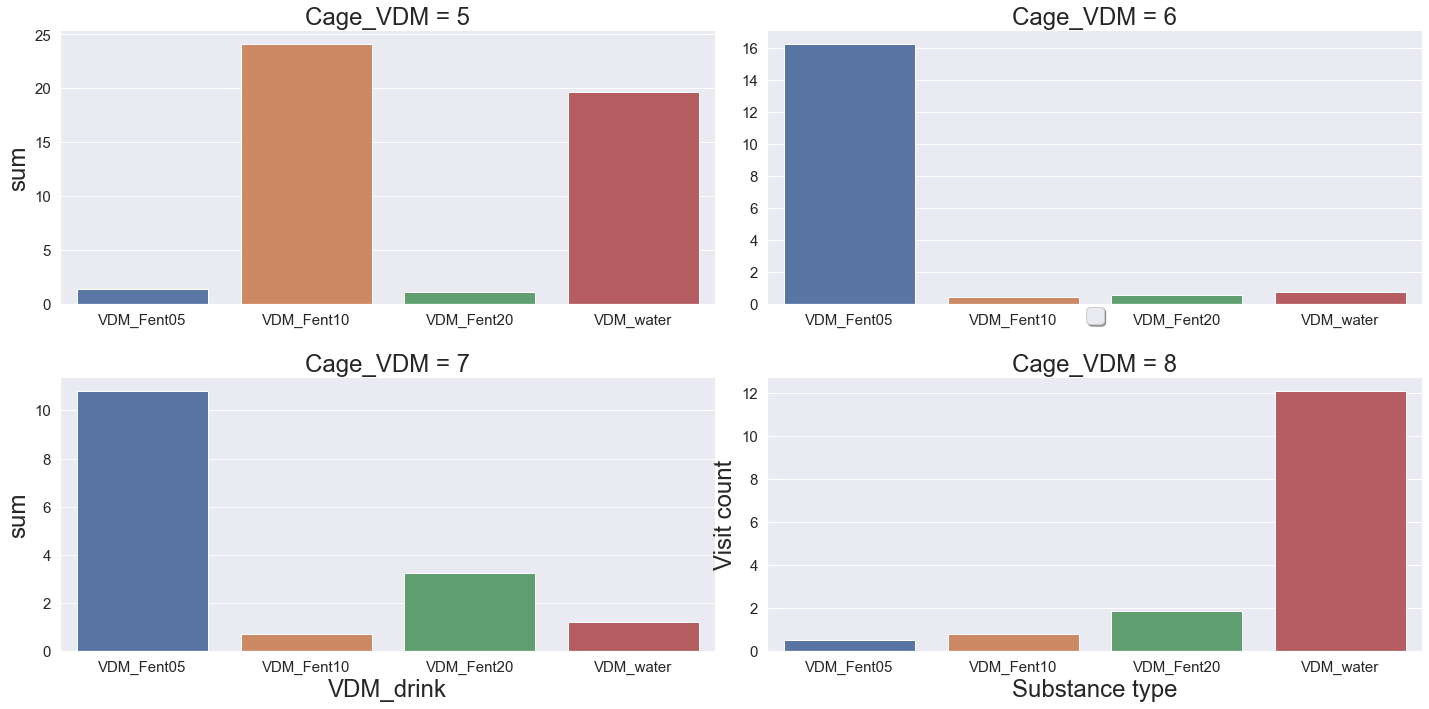

In [52]:
data_int = data_VDM_tidy_intake.groupby(['Cage_VDM', 'VDM_drink'])['value'].sum().reset_index(name='sum')

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.catplot(data=data_int, x="VDM_drink", y='sum', kind='bar', height=5, aspect=2, 
            col='Cage_VDM', col_wrap=2, sharey=False, sharex=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

### Filter RFID data by VDM times

In [53]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['VDM_drink', 'VDM_datetime']).reset_index(drop=True)

print(data_VDM_tidy_intake.groupby('Cage_VDM')['VDM_drink'].value_counts())
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

Cage_VDM  VDM_drink 
5         VDM_Fent10    761
          VDM_water     606
          VDM_Fent05    43 
          VDM_Fent20    34 
6         VDM_Fent05    496
          VDM_water     29 
          VDM_Fent20    20 
          VDM_Fent10    19 
7         VDM_Fent05    339
          VDM_Fent20    98 
          VDM_water     46 
          VDM_Fent10    26 
8         VDM_water     446
          VDM_Fent20    68 
          VDM_Fent10    30 
          VDM_Fent05    18 
Name: VDM_drink, dtype: int64
(3079, 15)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink
0,5.10.20.h20_f_220406.csv,5,04/06/22 17:39:50,drink_1,0.032,2022-04-06 17:39:50,1.649267e+09,2022-04-06,6,17:39:50,17,39,50,light,VDM_Fent05
1,5.10.20.h20_f_220406.csv,5,04/06/22 18:18:13,drink_1,0.032,2022-04-06 18:18:13,1.649269e+09,2022-04-06,6,18:18:13,18,18,13,dark_pm,VDM_Fent05
2,5.10.20.h20_f_220406.csv,7,04/06/22 18:29:14,drink_1,0.031,2022-04-06 18:29:14,1.649270e+09,2022-04-06,6,18:29:14,18,29,14,dark_pm,VDM_Fent05
3,5.10.20.h20_f_220406.csv,6,04/06/22 18:34:31,drink_1,0.031,2022-04-06 18:34:31,1.649270e+09,2022-04-06,6,18:34:31,18,34,31,dark_pm,VDM_Fent05
4,5.10.20.h20_f_220406.csv,5,04/06/22 19:08:43,drink_1,0.032,2022-04-06 19:08:43,1.649272e+09,2022-04-06,6,19:08:43,19,8,43,dark_pm,VDM_Fent05


In [54]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
print(data_RFID_final['unitLabel_drink'].value_counts())
data_RFID_final.head()

fent_05    13887
water      10587
fent_10    7901 
fent_20    5635 
Name: unitLabel_drink, dtype: int64


,Round,Build,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes
0,fentanyl,four_eight,na,5,041ABFE9B7,NaN,na,female,3,fent_05,Spyder1.21,1.031,light,light_day1,1,15,17,2,2022-04-06 15:17:02.244969600,2022-04-06 15:17:03.275969600,15:17:02,15:17:03,917,55022,15,917,54962,Idspyder-22.04.06.csv,25.5,NaN,NaN,NaN
1,fentanyl,four_eight,na,5,041AC16B6B,NaN,na,female,3,fent_05,Spyder1.21,1.373,light,light_day1,1,15,17,21,2022-04-06 15:17:21.590966400,2022-04-06 15:17:22.963966400,15:17:21,15:17:22,917,55041,15,917,54981,Idspyder-22.04.06.csv,22.7,NaN,NaN,NaN
2,fentanyl,four_eight,na,5,041AC16249,NaN,na,female,3,fent_05,Spyder1.21,0.642,light,light_day1,1,15,17,39,2022-04-06 15:17:39.178982400,2022-04-06 15:17:39.820982400,15:17:39,15:17:39,917,55059,15,917,54999,Idspyder-22.04.06.csv,21.3,NaN,NaN,NaN
3,fentanyl,four_eight,na,6,041AC16225,NaN,na,female,1,fent_05,Spyder1.21,0.573,light,light_day1,1,15,18,31,2022-04-06 15:18:31.633977600,2022-04-06 15:18:32.206977600,15:18:31,15:18:32,918,55111,15,918,55051,Idspyder-22.04.06.csv,21.1,NaN,NaN,NaN
4,fentanyl,four_eight,na,7,041AC165AE,NaN,na,female,1,fent_05,Spyder1.21,0.458,light,light_day1,1,15,18,48,2022-04-06 15:18:48.321014400,2022-04-06 15:18:48.779014400,15:18:48,15:18:48,918,55128,15,918,55068,Idspyder-22.04.06.csv,21.1,NaN,NaN,NaN


In [ ]:
flavor_mapping = {'VDM_EtOH05': 'etoh_05',
                  'VDM_EtOH10': 'etoh_10',
                  'VDM_EtOH20': 'etoh_20',
                  'VDM_water': 'water'}

flavor_mapping = {'VDM_Fent05': 'fent_05',
                  'VDM_Fent10': 'fent_10',
                  'VDM_Fent20': 'fent_20',
                  'VDM_water': 'water'}

In [55]:
data_comb = data_VDM_tidy_intake

flavor_mapping = {'VDM_Fent05': 'fent_05',
                  'VDM_Fent10': 'fent_10',
                  'VDM_Fent20': 'fent_20',
                  'VDM_water': 'water'}

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []

ld_cycle = []
ld_day = []
for index, row in data_comb.iterrows():
    if index%1000 == 0:
        print(index)
        
    #find RFID signal start time closest to VDM time before
    try:
        int_assign = data_RFID_final[(data_RFID_final['Cage'] == int(row['Cage_VDM'])) & #match cage
                               (data_RFID_final['unitLabel_drink'] == flavor_mapping[row['VDM_drink']]) & #match tube
                               (data_RFID_final['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel_drink'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])

        ld_cycle.append(int_assign['ld_cycle'])
        ld_day.append(int_assign['ld_day'])
        
    except:
        print(index, 'pre', row['Cage_VDM'])
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)

        ld_cycle.append(np.nan)
        ld_day.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre

data_comb['ld_cycle'] = ld_cycle
data_comb['ld_day'] = ld_day


print(data_comb.shape)
data_comb.head()

0
1000
2000
3000
(3079, 22)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day
0,5.10.20.h20_f_220406.csv,5,04/06/22 17:39:50,drink_1,0.032,2022-04-06 17:39:50,1.649267e+09,2022-04-06,6,17:39:50,17,39,50,light,VDM_Fent05,10.849,041AC16B6B,fent_05,2022-04-06 17:39:47.865974400,2022-04-06 17:39:58.714974400,light,light_day1
1,5.10.20.h20_f_220406.csv,5,04/06/22 18:18:13,drink_1,0.032,2022-04-06 18:18:13,1.649269e+09,2022-04-06,6,18:18:13,18,18,13,dark_pm,VDM_Fent05,7.296,041AC16B6B,fent_05,2022-04-06 18:18:10.124006400,2022-04-06 18:18:17.420006400,dark,dark_night1
2,5.10.20.h20_f_220406.csv,7,04/06/22 18:29:14,drink_1,0.031,2022-04-06 18:29:14,1.649270e+09,2022-04-06,6,18:29:14,18,29,14,dark_pm,VDM_Fent05,5.092,041AC165AE,fent_05,2022-04-06 18:21:20.597040000,2022-04-06 18:21:25.689040000,dark,dark_night1
3,5.10.20.h20_f_220406.csv,6,04/06/22 18:34:31,drink_1,0.031,2022-04-06 18:34:31,1.649270e+09,2022-04-06,6,18:34:31,18,34,31,dark_pm,VDM_Fent05,0.075,041AC16225,fent_05,2022-04-06 18:28:45.998976000,2022-04-06 18:28:46.073976000,dark,dark_night1
4,5.10.20.h20_f_220406.csv,5,04/06/22 19:08:43,drink_1,0.032,2022-04-06 19:08:43,1.649272e+09,2022-04-06,6,19:08:43,19,8,43,dark_pm,VDM_Fent05,0.858,041ABFE9B7,fent_05,2022-04-06 19:08:26.452032000,2022-04-06 19:08:27.310032000,dark,dark_night1


In [56]:
data_comb.isna().sum()

VDM_file                   0
Cage_VDM                   0
VDM_Time                   0
variable                   0
value                      0
VDM_datetime               0
VDM_timestamp              0
VDM_date                   0
VDM_day                    0
VDM_time                   0
VDM_hour                   0
VDM_min                    0
VDM_second                 0
ld_seg                     0
VDM_drink                  0
RFID_eventDuration         0
RFID_assign_id_pre         0
RFID_assign_var_pre        0
RFID_datetime_start_pre    0
RFID_datetime_end_pre      0
ld_cycle                   0
ld_day                     0
dtype: int64

In [57]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb['VDM_RFID_timediff_bool'] = ['same' if x==0 else 'diff' for x in data_comb['VDM_RFID_timediff']]

data_comb.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,5.10.20.h20_f_220406.csv,5,04/06/22 17:39:50,drink_1,0.032,2022-04-06 17:39:50,1.649267e+09,2022-04-06,6,17:39:50,17,39,50,light,VDM_Fent05,10.849,041AC16B6B,fent_05,2022-04-06 17:39:47.865974400,2022-04-06 17:39:58.714974400,light,light_day1,0.000000,same
1,5.10.20.h20_f_220406.csv,5,04/06/22 18:18:13,drink_1,0.032,2022-04-06 18:18:13,1.649269e+09,2022-04-06,6,18:18:13,18,18,13,dark_pm,VDM_Fent05,7.296,041AC16B6B,fent_05,2022-04-06 18:18:10.124006400,2022-04-06 18:18:17.420006400,dark,dark_night1,0.000000,same
2,5.10.20.h20_f_220406.csv,7,04/06/22 18:29:14,drink_1,0.031,2022-04-06 18:29:14,1.649270e+09,2022-04-06,6,18:29:14,18,29,14,dark_pm,VDM_Fent05,5.092,041AC165AE,fent_05,2022-04-06 18:21:20.597040000,2022-04-06 18:21:25.689040000,dark,dark_night1,468.310960,diff
3,5.10.20.h20_f_220406.csv,6,04/06/22 18:34:31,drink_1,0.031,2022-04-06 18:34:31,1.649270e+09,2022-04-06,6,18:34:31,18,34,31,dark_pm,VDM_Fent05,0.075,041AC16225,fent_05,2022-04-06 18:28:45.998976000,2022-04-06 18:28:46.073976000,dark,dark_night1,344.926024,diff
4,5.10.20.h20_f_220406.csv,5,04/06/22 19:08:43,drink_1,0.032,2022-04-06 19:08:43,1.649272e+09,2022-04-06,6,19:08:43,19,8,43,dark_pm,VDM_Fent05,0.858,041ABFE9B7,fent_05,2022-04-06 19:08:26.452032000,2022-04-06 19:08:27.310032000,dark,dark_night1,15.689968,diff


In [58]:
data_comb.groupby(['Cage_VDM', 'VDM_drink', ])['VDM_RFID_timediff_bool'].value_counts()

Cage_VDM  VDM_drink   VDM_RFID_timediff_bool
5         VDM_Fent05  same                      25 
                      diff                      18 
          VDM_Fent10  same                      708
                      diff                      53 
          VDM_Fent20  diff                      22 
                      same                      12 
          VDM_water   same                      492
                      diff                      114
6         VDM_Fent05  same                      445
                      diff                      51 
          VDM_Fent10  diff                      19 
          VDM_Fent20  diff                      19 
                      same                      1  
          VDM_water   diff                      28 
                      same                      1  
7         VDM_Fent05  same                      255
                      diff                      84 
          VDM_Fent10  diff                      26 
          VDM_Fent2

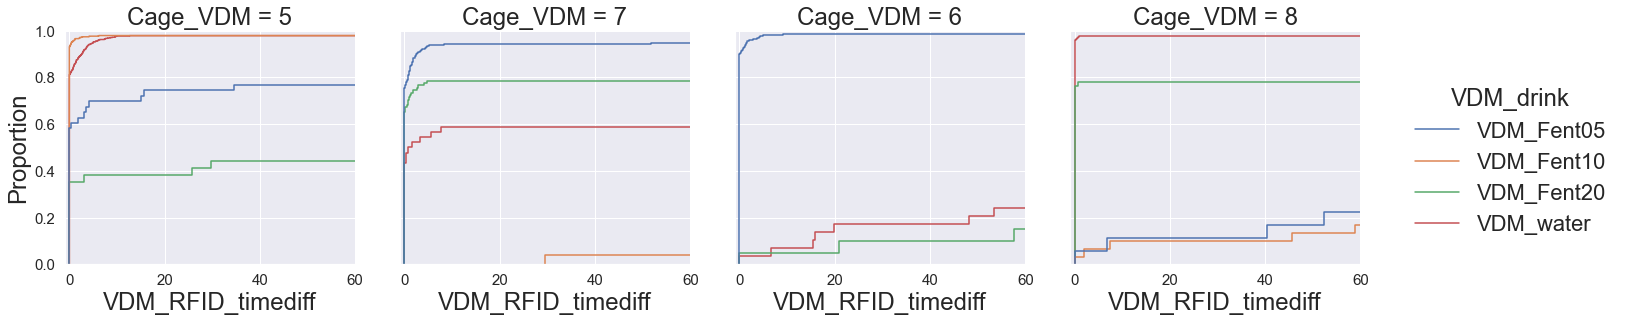

In [59]:
sns.displot(data=data_comb, x="VDM_RFID_timediff", kind="ecdf", hue='VDM_drink', col='Cage_VDM')

plt.xlim(-1, 60)
plt.show()

#### Add metadata

In [60]:
data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(3079, 40)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,0,5.10.20.h20_f_220406.csv,5,04/06/22 17:39:50,drink_1,0.032,2022-04-06 17:39:50,1.649267e+09,2022-04-06,6,17:39:50,17,39,50,light,VDM_Fent05,10.849,041AC16B6B,fent_05,2022-04-06 17:39:47.865974400,2022-04-06 17:39:58.714974400,light,light_day1,0.000000,same
1,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,1,5.10.20.h20_f_220406.csv,5,04/06/22 18:18:13,drink_1,0.032,2022-04-06 18:18:13,1.649269e+09,2022-04-06,6,18:18:13,18,18,13,dark_pm,VDM_Fent05,7.296,041AC16B6B,fent_05,2022-04-06 18:18:10.124006400,2022-04-06 18:18:17.420006400,dark,dark_night1,0.000000,same
2,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,21,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:23,drink_1,0.032,2022-04-07 10:13:23,1.649326e+09,2022-04-07,7,10:13:23,10,13,23,light,VDM_Fent05,2.343,041AC16B6B,fent_05,2022-04-06 20:35:11.256979200,2022-04-06 20:35:13.599979200,dark,dark_night1,49089.400020,diff
3,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,22,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:25,drink_1,0.032,2022-04-07 10:13:25,1.649326e+09,2022-04-07,7,10:13:25,10,13,25,light,VDM_Fent05,2.343,041AC16B6B,fent_05,2022-04-06 20:35:11.256979200,2022-04-06 20:35:13.599979200,dark,dark_night1,49091.400020,diff
4,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,252,5.10.20.h20_f_220406.csv,5,04/08/22 12:00:20,drink_1,0.032,2022-04-08 12:00:20,1.649419e+09,2022-04-08,8,12:00:20,12,0,20,light,VDM_Fent05,0.075,041AC16B6B,fent_05,2022-04-08 11:57:08.715974400,2022-04-08 11:57:08.790974400,light,light_day3,191.209025,diff


#### Add day, hour, and min counts

In [61]:
#column of running day count
dat_map = dict(zip(data_comb['VDM_date'].sort_values().unique(), np.arange(1,len(data_comb['VDM_date'].unique())+1)))
data_comb['day_count'] = data_comb['VDM_date'].map(dat_map)

#column of running min and second count within each day
data_comb['min_count'] = (data_comb['VDM_hour']*60) + data_comb['VDM_min'] 
data_comb['sec_count'] = (data_comb['min_count']*60) + data_comb['VDM_second'] 

#column of running hour and minute count across all days
data_comb['hour_count_running'] = (data_comb['day_count']*24) + data_comb['VDM_hour'] - 24
data_comb['min_count_running'] = (data_comb['hour_count_running']*60) + data_comb['VDM_min'] 
data_comb['sec_count_running'] = (data_comb['min_count_running']*60) + data_comb['VDM_second'] - 60

#ld
#data_comb['LD'] = [x.split('_')[0] for x in data_comb['ld']]

print(data_comb.shape)
data_comb.head()

(3079, 46)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool,day_count,min_count,sec_count,hour_count_running,min_count_running,sec_count_running
0,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,0,5.10.20.h20_f_220406.csv,5,04/06/22 17:39:50,drink_1,0.032,2022-04-06 17:39:50,1.649267e+09,2022-04-06,6,17:39:50,17,39,50,light,VDM_Fent05,10.849,041AC16B6B,fent_05,2022-04-06 17:39:47.865974400,2022-04-06 17:39:58.714974400,light,light_day1,0.000000,same,1,1059,63590,17,1059,63530
1,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,1,5.10.20.h20_f_220406.csv,5,04/06/22 18:18:13,drink_1,0.032,2022-04-06 18:18:13,1.649269e+09,2022-04-06,6,18:18:13,18,18,13,dark_pm,VDM_Fent05,7.296,041AC16B6B,fent_05,2022-04-06 18:18:10.124006400,2022-04-06 18:18:17.420006400,dark,dark_night1,0.000000,same,1,1098,65893,18,1098,65833
2,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,21,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:23,drink_1,0.032,2022-04-07 10:13:23,1.649326e+09,2022-04-07,7,10:13:23,10,13,23,light,VDM_Fent05,2.343,041AC16B6B,fent_05,2022-04-06 20:35:11.256979200,2022-04-06 20:35:13.599979200,dark,dark_night1,49089.400020,diff,2,613,36803,34,2053,123143
3,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,22,5.10.20.h20_f_220406.csv,5,04/07/22 10:13:25,drink_1,0.032,2022-04-07 10:13:25,1.649326e+09,2022-04-07,7,10:13:25,10,13,25,light,VDM_Fent05,2.343,041AC16B6B,fent_05,2022-04-06 20:35:11.256979200,2022-04-06 20:35:13.599979200,dark,dark_night1,49091.400020,diff,2,613,36805,34,2053,123145
4,fentanyl,four_eight,22.04.06,na,5,041AC16B6B,NaN,526.0,na,female,3,22.7,NaN,NaN,NaN,252,5.10.20.h20_f_220406.csv,5,04/08/22 12:00:20,drink_1,0.032,2022-04-08 12:00:20,1.649419e+09,2022-04-08,8,12:00:20,12,0,20,light,VDM_Fent05,0.075,041AC16B6B,fent_05,2022-04-08 11:57:08.715974400,2022-04-08 11:57:08.790974400,light,light_day3,191.209025,diff,3,720,43220,60,3600,215960


In [62]:
data_comb['substance'] = [x.split('_')[-1] for x in data_comb['VDM_drink']]

In [63]:
data_comb.to_csv('fent_220406.csv')